In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from keras import backend as k
import numpy as np
from matplotlib import pyplot as plt
import cv2
import random
import os
import sklearn
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

In [3]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.12.0


In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
    strategy = tf.distribute.TPUStrategy(tpu)
    print("on TPU")
except tf.errors.NotFoundError:
    print("not on TPU")
    strategy = tf.distribute.MirroredStrategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

In [4]:
tf.config.run_functions_eagerly(True)

In [5]:
tf.data.experimental.enable_debug_mode()

In [6]:
def multi_unet_model(IMG_SIZE,IMG_CHANNELS,N_CLASSES, activation_ ):
    IMG_HEIGHT,IMG_WIDTH = IMG_SIZE

  ###INPUT###

    inputs = tf.keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
#     s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

  ###ENCODING LAYER###

    c1 = tf.keras.layers.Conv2D(8,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(8,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c1)
    p1 = tf.keras.layers.MaxPool2D((2,2))(c1)

    c2 = tf.keras.layers.Conv2D(8*2,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(8*2,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c2)
    p2 = tf.keras.layers.MaxPool2D((2,2))(c2)

    c3 = tf.keras.layers.Conv2D(8*4,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(p2)
    c3 = tf.keras.layers.Dropout(0.1)(c3)
    c3 = tf.keras.layers.Conv2D(8*4,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c3)
    p3 = tf.keras.layers.MaxPool2D((2,2))(c3)

    c4 = tf.keras.layers.Conv2D(8*8,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(p3)
    c4 = tf.keras.layers.Dropout(0.1)(c4)
    c4 = tf.keras.layers.Conv2D(8*8,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c4)
    p4 = tf.keras.layers.MaxPool2D((2,2))(c4)

    c5 = tf.keras.layers.Conv2D(8*16,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(p4)
    c5 = tf.keras.layers.Dropout(0.1)(c5)
    c5 = tf.keras.layers.Conv2D(8*16,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c5)

  ##DECODING LAYER###

    c6 = tf.keras.layers.Conv2DTranspose(8*8,(2,2),strides = (2,2),padding = 'same')(c5)
    c6 = tf.keras.layers.concatenate([c6,c4])
    c6 = tf.keras.layers.Conv2D(8*8,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(c6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(8*8,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c6)

    c7 = tf.keras.layers.Conv2DTranspose(8*4,(2,2),strides = (2,2),padding = 'same')(c6)
    c7 = tf.keras.layers.concatenate([c7,c3])
    c7 = tf.keras.layers.Conv2D(8*4,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(c7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(8*4,(3,3),activation =activation_, kernel_initializer='he_normal',padding = 'same')(c7)

    c8 = tf.keras.layers.Conv2DTranspose(8*2,(2,2),strides = (2,2),padding = 'same')(c7)
    c8 = tf.keras.layers.concatenate([c8,c2])
    c8 = tf.keras.layers.Conv2D(8*2,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(c8)
    c8 = tf.keras.layers.Dropout(0.2)(c8)
    c8 = tf.keras.layers.Conv2D(8*2,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c8)

    c9 = tf.keras.layers.Conv2DTranspose(8,(2,2),strides = (2,2),padding = 'same')(c8)
    c9 = tf.keras.layers.concatenate([c9,c1])
    c9 = tf.keras.layers.Conv2D(8,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(c9)
    c9 = tf.keras.layers.Dropout(0.2)(c9)
    c9 = tf.keras.layers.Conv2D(8,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c9)

  ###OUTPUT###

    outputs = tf.keras.layers.Conv2D(N_CLASSES,(1,1),activation = 'sigmoid')(c9)

  ###MODEL###

    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])

    return model

In [7]:
class LearnableSwish(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LearnableSwish, self).__init__(**kwargs)

    def build(self, input_shape):
        self.beta = self.add_weight(shape=(1, ), initializer="ones", trainable=True)
        super(LearnableSwish, self).build(input_shape)

    def call(self, inputs):
        return tf.nn.swish(inputs * self.beta)
    
class Mish(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs * tf.math.tanh(tf.math.softplus(inputs))

class GeLu(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GeLu, self).__init__(**kwargs)

    def call(self, inputs):
        return 0.5 * inputs * (1 + tf.math.tanh(tf.sqrt(2 / tf.constant(3.141592653589793)) * (inputs + 0.044715 * tf.math.pow(inputs, 3))))
    
class PReLu(tf.keras.layers.Layer):
    def __init__(self, alpha_initializer='zeros', alpha_regularizer=tf.keras.regularizers.l2(0.01), alpha_constraint=tf.keras.constraints.min_max_norm(min_value=0.0, max_value=1.0), **kwargs):
        super(PReLu, self).__init__(**kwargs)
        self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)
        self.alpha_regularizer = tf.keras.regularizers.get(alpha_regularizer)
        self.alpha_constraint = tf.keras.constraints.get(alpha_constraint)

    def build(self, input_shape):
        self.alpha = self.add_weight(shape=(1, ), initializer=self.alpha_initializer, regularizer=self.alpha_regularizer, constraint=self.alpha_constraint, name='alpha', trainable=True)
        super(PReLu, self).build(input_shape)

    def call(self, inputs):
        pos = tf.nn.relu(inputs)
        neg = self.alpha * (inputs - tf.abs(inputs)) * 0.5
        return pos + neg
    
class ELU(tf.keras.layers.Layer):
    def __init__(self, alpha_initializer='ones', **kwargs):
        super(ELU, self).__init__(**kwargs)
        self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)

    def build(self, input_shape):
        self.alpha = self.add_weight(
            shape=(1,),
            initializer=self.alpha_initializer,
            trainable=True,
            name='alpha'
        )
        super(ELU, self).build(input_shape)

    def call(self, inputs):
        return tf.where(inputs >= 0, inputs, self.alpha * (tf.exp(inputs) - 1))

    def compute_output_shape(self, input_shape):
        return input_shape
    
class SELU(tf.keras.layers.Layer):
    def __init__(self, alpha_initializer='zeros', lambda_initializer='ones', **kwargs):
        super(SELU, self).__init__(**kwargs)
        self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)
        self.lambda_initializer = tf.keras.initializers.get(lambda_initializer)

    def build(self, input_shape):
        self.alpha = self.add_weight(
            shape=(input_shape[-1],),
            initializer=self.alpha_initializer,
            trainable=True,
            name='alpha'
        )
        self.lambda_ = self.add_weight(
            shape=(input_shape[-1],),
            initializer=self.lambda_initializer,
            trainable=True,
            name='lambda'
        )
        super(SELU, self).build(input_shape)

    def call(self, inputs):
        return self.lambda_ * tf.where(inputs >= 0, inputs, self.alpha * tf.nn.elu(inputs))

    def compute_output_shape(self, input_shape):
        return input_shape
    
class GLU(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='glorot_uniform', alpha_initializer='zeros', **kwargs):
        super(GLU, self).__init__(**kwargs)
        self.units = units
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(input_dim, self.units),
            initializer=self.kernel_initializer,
            trainable=True,
            name='kernel'
        )
        self.alpha = self.add_weight(
            shape=(1,),
            initializer=self.alpha_initializer,
            trainable=True,
            name='alpha'
        )
        super(GLU, self).build(input_shape)

    def call(self, inputs):
        linear_output = tf.matmul(inputs, self.kernel)
        gated_output = self.alpha * tf.sigmoid(linear_output)
        return linear_output * gated_output

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.units,)
    
class ARCTAN(tf.keras.layers.Layer):
    def __init__(self, alpha_initializer='ones', **kwargs):
        super(ARCTAN, self).__init__(**kwargs)
        self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)

    def build(self, input_shape):
        self.alpha = self.add_weight(
            shape=(1,),
            initializer=self.alpha_initializer,
            trainable=True,
            name='alpha'
        )
        super(ARCTAN, self).build(input_shape)

    def call(self, inputs):
        return tf.atan(inputs * self.alpha)

    def compute_output_shape(self, input_shape):
        return input_shape
    
class NA(tf.keras.layers.Layer):
    def __init__(self, alpha_initializer='ones', **kwargs):
        super(NA, self).__init__(**kwargs)
        self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)

    def build(self, input_shape):
        self.alpha = self.add_weight(
            shape=(1,),
            initializer=self.alpha_initializer,
            trainable=True,
            name='alpha'
        )
        super(NA, self).build(input_shape)

    def call(self, inputs):
        return tf.where(inputs >= 0, self.alpha * (1 - tf.exp(-inputs)), tf.exp(inputs) - 1)

    def compute_output_shape(self, input_shape):
        return input_shape

In [7]:
def multi_unet_model_GLU(IMG_SIZE, IMG_CHANNELS, N_CLASSES):
    IMG_HEIGHT, IMG_WIDTH = IMG_SIZE

    ###INPUT###
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    ###ENCODING LAYER###
    c1 = GLU(units=8)(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = GLU(units=8)(c1)
    p1 = tf.keras.layers.MaxPool2D((2, 2))(c1)

    c2 = GLU(units=8*2)(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = GLU(units=8*2)(c2)
    p2 = tf.keras.layers.MaxPool2D((2, 2))(c2)

    c3 = GLU(units=8*4)(p2)
    c3 = tf.keras.layers.Dropout(0.1)(c3)
    c3 = GLU(units=8*4)(c3)
    p3 = tf.keras.layers.MaxPool2D((2, 2))(c3)

    c4 = GLU(units=8*8)(p3)
    c4 = tf.keras.layers.Dropout(0.1)(c4)
    c4 = GLU(units=8*8)(c4)
    p4 = tf.keras.layers.MaxPool2D((2, 2))(c4)

    c5 = GLU(units=8*16)(p4)
    c5 = tf.keras.layers.Dropout(0.1)(c5)
    c5 = GLU(units=8*16)(c5)

    ##DECODING LAYER##
    c6 = tf.keras.layers.Conv2DTranspose(8*8, (2, 2), strides=(2, 2), padding='same')(c5)
    c6 = tf.keras.layers.concatenate([c6, c4])
    c6 = GLU(units=8*8)(c6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = GLU(units=8*8)(c6)

    c7 = tf.keras.layers.Conv2DTranspose(8*4, (2, 2), strides=(2, 2), padding='same')(c6)
    c7 = tf.keras.layers.concatenate([c7, c3])
    c7 = GLU(units=8*4)(c7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = GLU(units=8*4)(c7)

    c8 = tf.keras.layers.Conv2DTranspose(8*2, (2, 2), strides=(2, 2), padding='same')(c7)
    c8 = tf.keras.layers.concatenate([c8, c2])
    c8 = GLU(units=8*2)(c8)
    c8 = tf.keras.layers.Dropout(0.2)(c8)
    c8 = GLU(units=8*2)(c8)

    c9 = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c8)
    c9 = tf.keras.layers.concatenate([c9, c1])
    c9 = GLU(units=8)(c9)
    c9 = tf.keras.layers.Dropout(0.2)(c9)
    c9 = GLU(units=8)(c9)

    ###OUTPUT###
    outputs = tf.keras.layers.Conv2D(N_CLASSES, (1, 1), activation='sigmoid')(c9)

    ###MODEL###
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

In [8]:
DATA_DIR = "/kaggle/input/lung-mask-image-dataset/ChestXray"
SET = ["train/","test/","val/"]

In [9]:
def make_patch(img):
    patch1 = img[:256,:256]
    patch2 = img[:256,256:]
    patch3 = img[256:,256:]
    patch4 = img[256:,:256]
    
    return [patch1,patch2,patch3,patch4]

In [10]:
XTRAIN = []
YTRAIN = []

TRAIN_PARENT_PATH = os.path.join(DATA_DIR,SET[0])
TRAIN_IMG_PATH = TRAIN_PARENT_PATH + 'image/'
TRAIN_MASK_PATH = TRAIN_PARENT_PATH + 'mask/'
count = 0

for img in os.listdir(TRAIN_IMG_PATH):
    if count<400:
        IMG_PATH = os.path.join(TRAIN_IMG_PATH,img)
        img_array = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
        img_array.resize(512,512,1)
        XTRAIN.append(img_array)
        count += 1
    else:
        print("XTRAIN DONE")
        break
        
count = 0

for mask in os.listdir(TRAIN_MASK_PATH):
    if count<400:
        MASK_PATH = os.path.join(TRAIN_MASK_PATH,mask)
        img_array = cv2.imread(MASK_PATH,cv2.IMREAD_GRAYSCALE)
        img_array.resize(512,512,1)
        YTRAIN.append(img_array)
        count += 1
    else:
        print("YTRAIN DONE")
        break

XTRAIN DONE
YTRAIN DONE


In [11]:
def masking_ratio(img,shape):
    x,y = shape
    num_ones = np.sum(img)
    num_zeros = x*y - num_ones
    return num_ones/(num_ones + num_zeros)

In [12]:
XTRAIN = np.array(XTRAIN).reshape(-1,512,512,1)/511
YTRAIN = np.array(YTRAIN).reshape(-1,512,512,1).astype('float32')
print("DONE")

DONE


In [13]:
masking_ratio_values = np.zeros(len(YTRAIN))
for i in range(len(YTRAIN)):
    masking_ratio_values[i] = masking_ratio(YTRAIN[i],[512,512])

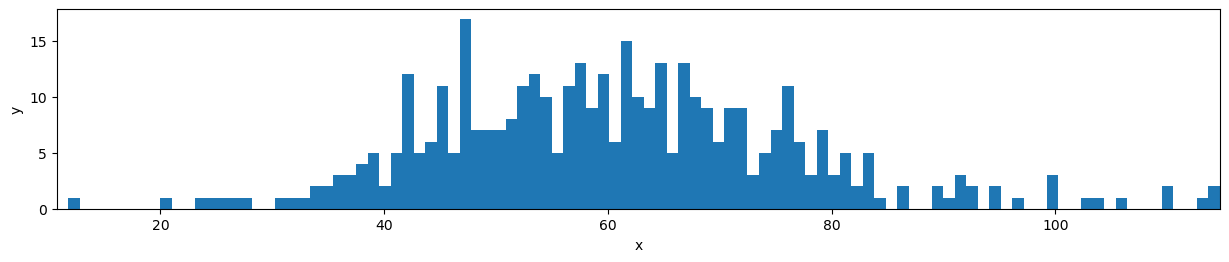

In [15]:
# plt.style.use("dark_background")
plt.figure(figsize=(15,15))
plt.hist(masking_ratio_values,bins=100)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(min(masking_ratio_values)-1, max(masking_ratio_values))
# plt.ylim(0, 1000)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [14]:
import math

mean = np.mean(masking_ratio_values)
std = np.std(masking_ratio_values)
left_cutoff = math.ceil(mean - 2*std)
right_cutoff = math.ceil(mean + 2*std)

print(left_cutoff,right_cutoff)

29 93


In [14]:
indices = []
for i in range(len(YTRAIN)):    
    if masking_ratio_values[i]<=30 or masking_ratio_values[i]>=90:
        indices.append(i)
        
YTRAIN = np.delete(YTRAIN, indices, axis = 0)
XTRAIN = np.delete(XTRAIN, indices, axis = 0)

In [15]:
print(XTRAIN.shape)
YTRAIN = YTRAIN.astype(bool)

(373, 512, 512, 1)


In [16]:
PATCH_XTRAIN = []
PATCH_YTRAIN = []

for img in XTRAIN:
    PATCH_XTRAIN.extend(make_patch(img))
    
print("PATCH_XTRAIN DONE")

for mask in YTRAIN:
    PATCH_YTRAIN.extend(make_patch(mask))
    
print("PATCH_YTRAIN DONE")

PATCH_XTRAIN DONE
PATCH_YTRAIN DONE


In [17]:
PATCH_XTRAIN = np.array(PATCH_XTRAIN).reshape(-1,256,256,1)
PATCH_YTRAIN = np.array(PATCH_YTRAIN).reshape(-1,256,256,1)
print(PATCH_XTRAIN.shape)
print(PATCH_YTRAIN.shape)

(1492, 256, 256, 1)
(1492, 256, 256, 1)


In [18]:
PATCH_XTRAIN,PATCH_YTRAIN = sklearn.utils.shuffle(PATCH_XTRAIN,PATCH_YTRAIN)

In [ ]:
plt.imshow(PATCH_XTRAIN[1],cmap = 'gray')

In [ ]:
plt.imshow(PATCH_YTRAIN[1],cmap = 'gray')

In [ ]:
VAL_XTRAIN = []
VAL_YTRAIN = []

TRAIN_PARENT_PATH = os.path.join(DATA_DIR,SET[2])
VAL_TRAIN_IMG_PATH = TRAIN_PARENT_PATH + 'image/'
VAL_TRAIN_MASK_PATH = TRAIN_PARENT_PATH + 'mask/'

for img in os.listdir(VAL_TRAIN_IMG_PATH):
    IMG_PATH = os.path.join(VAL_TRAIN_IMG_PATH,img)
    img_array = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
    img_array.resize(256,256,1)
    VAL_XTRAIN.append(img_array)
        
for mask in os.listdir(VAL_TRAIN_MASK_PATH):
    MASK_PATH = os.path.join(VAL_TRAIN_MASK_PATH,mask)
    img_array = cv2.imread(MASK_PATH,cv2.IMREAD_GRAYSCALE)
    img_array.resize(256,256,1)
    VAL_YTRAIN.append(img_array)

In [ ]:
XTRAIN = np.array(XTRAIN).reshape(-1,256,256,1)
YTRAIN = np.array(YTRAIN).reshape(-1,256,256,1)

In [ ]:
plt.imshow(VAL_XTRAIN[0],cmap = 'gray')

In [ ]:
plt.imshow(VAL_YTRAIN[0],cmap = 'gray')

In [25]:
XTEST = []
YTEST = []

TEST_PARENT_PATH = os.path.join(DATA_DIR,SET[1])
TEST_IMG_PATH = TEST_PARENT_PATH + 'image/'
TEST_MASK_PATH = TEST_PARENT_PATH + 'mask/'
count = 0

for img in os.listdir(TEST_IMG_PATH):
    if count<1:
        IMG_PATH = os.path.join(TEST_IMG_PATH,img)
        img_array = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
        img_array.resize(512,512,1)
        XTEST.append(img_array)
        count += 1
print("XTEST DONE")
count = 0

for mask in os.listdir(TEST_MASK_PATH):
    if count<1:
        MASK_PATH = os.path.join(TEST_MASK_PATH,mask)
        img_array = cv2.imread(MASK_PATH,cv2.IMREAD_GRAYSCALE)
        img_array.resize(512,512,1)
        YTEST.append(img_array)
        count += 1
        
print("YTEST done")

XTEST DONE
YTEST done


In [26]:
XTEST = np.array(XTEST).reshape(-1,512,512,1)/511
YTEST = np.array(YTEST).reshape(-1,512,512,1).astype(bool)
print("DONE")

DONE


In [ ]:
masking_ratio_values = np.zeros(len(YTEST))
for i in range(len(YTEST)):
    masking_ratio_values[i] = masking_ratio(YTEST[i],[512,512])

In [ ]:
plt.style.use("dark_background")
plt.figure(figsize=(15,15))
plt.hist(masking_ratio_values,bins=100)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(min(masking_ratio_values)-1, max(masking_ratio_values))
# plt.ylim(0, 1000)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
XTRAIN.shape

In [27]:
PATCH_XTEST = []
PATCH_YTEST = []

for img in XTEST:
    PATCH_XTEST.extend(make_patch(img))
    
print("PATCH_XTEST DONE")

for mask in YTEST:
    PATCH_YTEST.extend(make_patch(mask))
    
print("PATCH_YTEST DONE")

PATCH_XTEST DONE
PATCH_YTEST DONE


In [28]:
PATCH_XTEST = np.array(PATCH_XTEST).reshape(-1,256,256,1)
PATCH_YTEST = np.array(PATCH_YTEST).reshape(-1,256,256,1)
print(PATCH_XTEST.shape)
print(PATCH_YTEST.shape)

(4, 256, 256, 1)
(4, 256, 256, 1)


In [ ]:
plt.imshow(PATCH_XTEST[0],cmap = 'gray')

In [ ]:
plt.imshow(PATCH_YTEST[0],cmap = 'gray')

In [19]:
from keras import backend as K

def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
        
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def dice_coef(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice
    
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [20]:
#'prelu', 'elu', 'selu', 'swish','glu', 'arctan', 'bent_identity', and 'neuron_arc'

activation_name = 'relu'

In [21]:
# with strategy.scope():
model = multi_unet_model(IMG_SIZE = [256,256],IMG_CHANNELS = 1,N_CLASSES = 1,activation_ = 'relu')
    
model.compile(
        optimizer = 'adam',
        loss = [dice_coef_loss],
        metrics = [iou]
        )
    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['dropout[0][0]']            

In [2]:
# model = multi_unet_model_GLU(IMG_SIZE = [256,256],IMG_CHANNELS = 1,N_CLASSES = 1)
    
# model.compile(
#         optimizer = 'adam',
#         loss = [dice_coef_loss],
#         metrics = [iou]
#         )
    
# model.summary()

In [ ]:
history = model.fit(PATCH_XTRAIN,PATCH_YTRAIN,
                    batch_size = 64 ,validation_split = 0.33 ,
                    epochs = 100)

Epoch 1/100
16/16 [==============================] - 30s 1s/step - loss: -0.3465 - iou: 0.2109 - val_loss: -0.3974 - val_iou: 0.2475
Epoch 2/100
16/16 [==============================] - 10s 618ms/step - loss: -0.4003 - iou: 0.2506 - val_loss: -0.4059 - val_iou: 0.2541
Epoch 3/100
16/16 [==============================] - 10s 608ms/step - loss: -0.4020 - iou: 0.2511 - val_loss: -0.4064 - val_iou: 0.2545
Epoch 4/100
16/16 [==============================] - 10s 612ms/step - loss: -0.4024 - iou: 0.2519 - val_loss: -0.4064 - val_iou: 0.2545
Epoch 5/100
16/16 [==============================] - 10s 613ms/step - loss: -0.4029 - iou: 0.2522 - val_loss: -0.4100 - val_iou: 0.2574
Epoch 6/100
16/16 [==============================] - 9s 598ms/step - loss: -0.4114 - iou: 0.2588 - val_loss: -0.4428 - val_iou: 0.2839
Epoch 7/100
16/16 [==============================] - 10s 611ms/step - loss: -0.4461 - iou: 0.2869 - val_loss: -0.4580 - val_iou: 0.2966
Epoch 8/100
16/16 [==============================] -

In [29]:
yhat = model.predict(PATCH_XTEST)

1/1 [==============================] - 1s 668ms/step


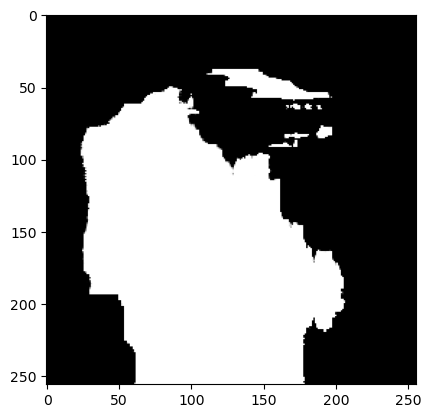

In [30]:
plt.imshow(yhat[1],cmap = 'gray')

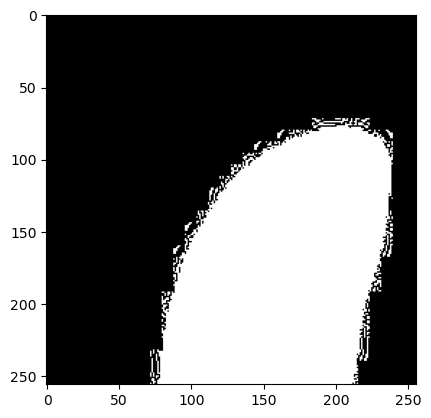

In [31]:
plt.imshow(PATCH_YTEST[0],cmap = 'gray')

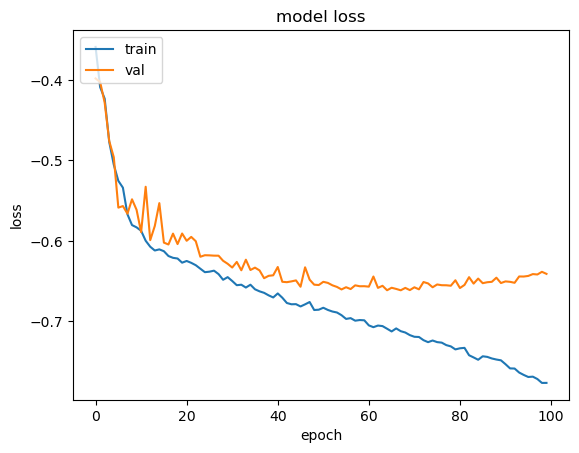

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

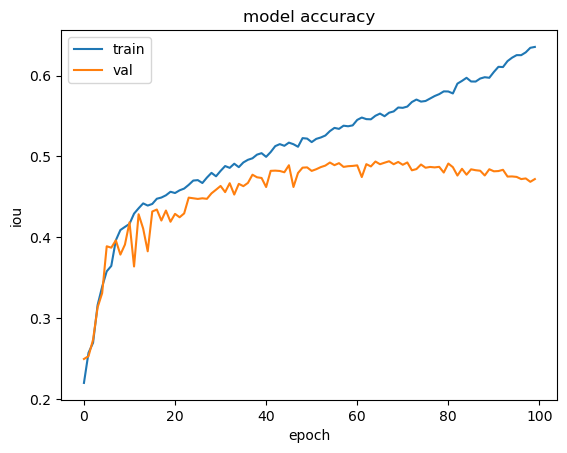

In [33]:
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('model accuracy')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
import pandas as pd

hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history_'+ activation_name + '.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)